This is a brief introduction to the endocytosis.simulation.simulator module, which at the moment contains only the `RandomSimulator` class. `RandomSimulator` simulates many 2D images containing diffraction-limited spots using the same point spread function (PSF) and noise models. Ground truth data, i.e. the centroid locations of each spot, and image data can be saved into one HDF5 file.

Here's boilerplate code similar to that of image_simulation.py, including generating the PSF and noise models:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py
import random
from fijitools.helpers.coordinate import Coordinate

In [3]:
from endocytosis.simulation.image_components import FieldOfView, Spot
from endocytosis.simulation.psfmodel import SimpleGaussian2D
from endocytosis.simulation.noise import NoiseModel
from endocytosis.simulation.simulator import RandomSimulator
%matplotlib inline

In [4]:
PIXELSIZE = Coordinate(px=(1., 1.), nm=(80., 80.))

In [5]:
sigma = Coordinate(nm=(100., 100.))

In [6]:
sigma.pixelsize = PIXELSIZE
psf = SimpleGaussian2D(sigma)

In [7]:
path = os.path.abspath(os.path.join(os.pardir, 'endocytosis', 'test', 'simulation', 'data', 'camera.yaml'))
nm = NoiseModel()
nm.load_camera_metadata(path, 'X-9309')
nm.use_camera(True, 30, 2)

In [7]:
# pixelsize can only be set if psfmodel's pixelsize hasn't been set
del psf.sigma['px']
fov = FieldOfView((128, 128), PIXELSIZE, psfmodel=psf, noise_model=nm)

Below is code not introduced in image_simulation.ipynb. 

First, we instantiate a RandomSimulator object, providing the following arguments in the constructor:

    1. density: a maximum of one Spot may placed every [density, density] number of pixels. If None, Spot centroid 
    coördinates are totally random
    2. args: arguments to set the FieldOfView

We set the `FieldOfView` object by either passing in an existing `FieldOfView` or parameters for instantiating a `FieldOfView` (`image_shape`, `pixelsize`, `psfmodel`, and `noise_model`). The process of simulating an image is first adding `Spots` at random locations in the 2D image, and then calling the `FieldOfView's` `render` method to draw the `Spots`, i.e. set pixel values. After each image is rendered in this way, it and its corresponding ground truth data are written to the HDF5 file. All this -- generating `Spot` objects, adding them to the `FieldOfView`, writing to HDF5 -- this is all performed by the `simulate` method.

In [8]:
try:
    rsm.cleanup()
except:
    pass
if os.path.isfile('multi_image_simulator.h5'):
    os.remove('multi_image_simulator.h5')
rsm = RandomSimulator(1, fov)

We must also create an HDF5 file where simulated data is saved. This is done by the set_h5file method.

In [9]:
rsm.set_h5file('multi_image_simulator.h5')

The `simulate` method also requires an A parameter which is a generator that yields amplitude intensities when rendering the PSF.

In [17]:
def a():
    while True:
        yield random.random()*100

Into `simulate` we pass in parameters for the number of images (`nT`), the (min, max) number of `Spots` per image, selected from a uniform distribution, and the amplitude generator method.

In [18]:
rsm.simulate(nT=5, n_spots=(int(1e2)-1, int(1e2)), A=a())

We can use the `RandomSimulator`'s `render` and `centroids` methods to retrieve image and coördinate data, respectively. Select an image index with the `t` parameter. Note that due to the vagaries of `matplotlib.pyplot.plot`, we need to add 0.5 pixels to each coordinate so the marker is displayed correctly.

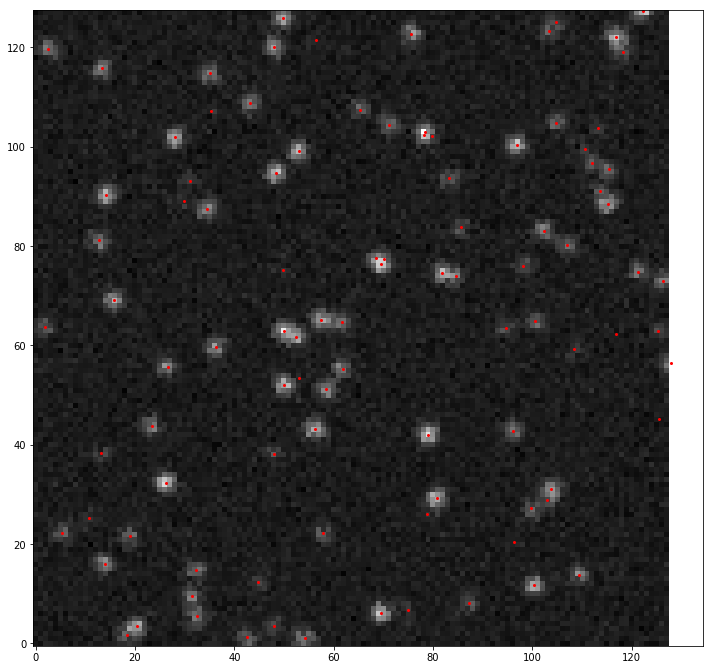

In [19]:
t = 0
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(rsm.render(t), cmap=plt.cm.gray, origin='lower')
y, x = rsm.centroids(t).T
ax.plot(x+0.5, y+0.5, 'ro', ms=2)

Note that `RandomSimulator` can be run as a context manager subclassed from `endocytosis.io.__init__`. Its environment-exiting function is implemented in `cleanup`, which simply closes the `h5py.File`. Let's do this manually below:

In [20]:
rsm.cleanup()